In [1]:
from qiskit import QuantumCircuit, QuantumRegister, BasicAer, IBMQ, execute

from qiskit.quantum_info import *

from qiskit.circuit import Parameter

from qiskit.ignis.verification import *

from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

from math import pi
import numpy as np

from qiskit.providers.ibmq import least_busy

In [2]:
theta1 = Parameter('$θ_1$')
phi1 = Parameter('$φ_1$')
lamb1 = Parameter('$λ_1$')

theta2 = Parameter('$θ_2$')
phi2 = Parameter('$φ_2$')
lamb2 = Parameter('$λ_2$')

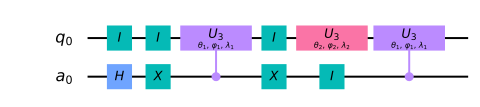

In [3]:
q = QuantumRegister(1, name='q')
a = QuantumRegister(1, name='a')
switch = QuantumCircuit(q, a, name='$\mathcal{S}$')

switch.id(0)
switch.id(0)
switch.h(1)
switch.x(1)
switch.cu3(theta1, phi1, lamb1, 1,0)
switch.x(1)
switch.id(0)
switch.id(1)
switch.u3(theta2, phi2, lamb2, 0)
switch.cu3(theta1, phi1, lamb1, 1,0)

switch.draw(output='mpl', plot_barriers=False, scale=0.6)

In [4]:
#bit-flip and phase-flip channels
instance = switch.bind_parameters({theta1:pi, phi1:0, lamb1:pi, theta2:0, phi2:0, lamb2:pi})

In [5]:
circuits = process_tomography_circuits(instance, [0])

In [6]:
account = IBMQ.load_account()

In [8]:
provider = IBMQ.get_provider('ibm-q')
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
j = execute(circuits, backend=backend, shots=8192)
job_monitor(j)

Job Status: job has successfully run


In [9]:
results = j.result()
fitter = ProcessTomographyFitter(results, circuits)

In [10]:
#rho: density matrix 2X2
#chi: process matrix 4X4
def superoperator(rho, chi):
    return [[rho[0][0]*chi[0][0] + rho[0][1]*chi[0][1] + rho[1][0]*chi[1][0] + rho[1][1]*chi[1][1],
            rho[0][0]*chi[0][2] + rho[0][1]*chi[0][3] + rho[1][0]*chi[1][2] + rho[1][1]*chi[1][3]],
           [rho[0][0]*chi[2][0] + rho[0][1]*chi[2][1] + rho[1][0]*chi[3][0] + rho[1][1]*chi[3][1],
            rho[0][0]*chi[2][2] + rho[0][1]*chi[2][3] + rho[1][0]*chi[3][2] + rho[1][1]*chi[3][3]]]


In [14]:
#chi_id: ideal process matrix for 2-qubit circuit
def trace_out_ancilla(chi_id):
    return partial_trace(chi_id.data, [1,3]).data / 2

In [12]:
#chi_id: ideal process matrix 4X4
#chi_ex: experimental process matrix 4X4
def process_fidelity(chi_id, chi_ex): 
    return np.trace(np.transpose(np.conjugate(chi_id)).dot(chi_ex))/4

In [15]:
chi_ex = fitter.fit().data # experimental
chi_id = trace_out_ancilla(Choi(instance)) # ideal

In [16]:
print(process_fidelity(chi_id, chi_ex))

(0.9213256835937514+0j)
